# Random Forest

En este notebook clasificaremos si una instancia tiene alto poder adquisitivo mediante RandomForest

Se utilizarán cuatro preprocessings diferentes:
* Las variables utilizadas en la primera parte del trabajo práctico.
* Todas las variables pero el data frame equilibrado
* Todas las variables sin modificación alguna
* PCA del 90% de la varianza.

In [2]:
# Modelo
from sklearn.ensemble import RandomForestClassifier

# Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import roc_curve, plot_roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# Plots
from matplotlib import pyplot as plt
import seaborn as sns

# Otros
import pandas as pd
from preprocessing import preprocessing_base_parte_1
from preprocessing import preprocessing_equilibrado
from preprocessing import preprocessing_significantes
import utils

In [3]:
df = utils.get_data()

### Modelo 1 - Preprocessing parte 1

Este RandomForest será entrenado con las siguientes variables:

* **Ganancia/Pérdida declara en la bolsa argentina**: `ganancia_perdida_declarada_bolsa_argentina`
* **Edad**: `edad`
* **Rol familiar registrado**: `rol_familiar_registrado`
* **Años estudiados**: `anios_estudiados`

Además, de los hiperparámetros rescatamos que entrenaremos un RandomForest que mirará un máximo de features de 2

In [4]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=27)

X_train_1, X_test_1 = preprocessing_base_parte_1(X_train_1, X_test_1)

#### Búsqueda de la mejor altura

In [5]:
params = { 'max_depth': range(2,18), 'n_estimators': range(50,1500,50), 'criterion': ['gini', 'entropy'] }
model = RandomForestClassifier(n_jobs=-1, random_state=27)
    
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose=5)

In [7]:
gscv.fit(X_train_1, y_train_1)

Fitting 4 folds for each of 928 candidates, totalling 3712 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s


KeyboardInterrupt: 

In [6]:
gscv.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

Vemos que la altura óptima que usaremos es de 11, con 1400 estimadores.

Por lo que crearemos el primer modelo:

In [8]:
rfc1 = RandomForestClassifier(n_estimators=1400,
                               criterion='entropy',
                               max_depth=11,
                               max_features=2,
                               oob_score=True,
                               n_jobs=-1,
                               random_state=27)

In [9]:
rfc1.fit(X_train_1, y_train_1)

RandomForestClassifier(criterion='entropy', max_depth=11, max_features=2,
                       n_estimators=1400, n_jobs=-1, oob_score=True,
                       random_state=27)

In [10]:
print(classification_report(y_test_1,rfc1.predict(X_test_1), digits=4))

              precision    recall  f1-score   support

           0     0.8737    0.9560    0.9130      6186
           1     0.8017    0.5627    0.6613      1955

    accuracy                         0.8616      8141
   macro avg     0.8377    0.7593    0.7871      8141
weighted avg     0.8564    0.8616    0.8526      8141



Buenas métricas para el primer modelo. Dado que la cantidad de features está limitada a 4 (es decir, el modelo está previamente sesgado por la selección).

Veamos cómo se comporta la matriz de confusión

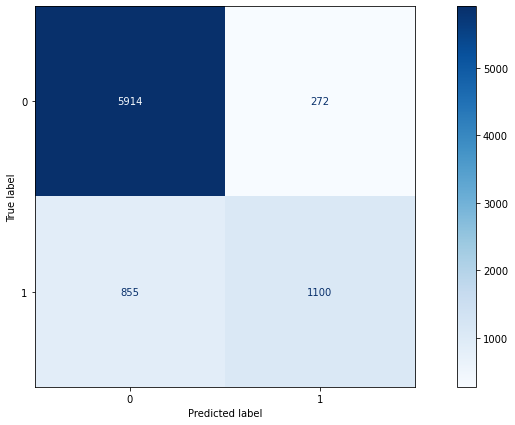

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(rfc1, X_test_1, y_test_1, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Vemos que, como ya es costumbre la cantidad de falsos negativos es muy alta, pero se mantuvo relativamente baja.

Veamos ahora las métricas de Roc_AUC

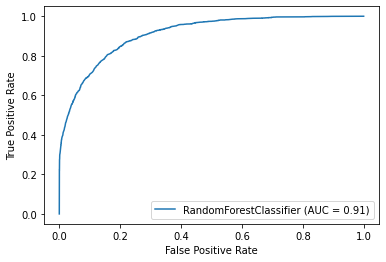

In [12]:
plot_roc_curve(rfc1, X_test_1, y_test_1)

In [13]:
print("El score de RocAUC es de: ", round(roc_auc_score(y_test_1, rfc1.predict_proba(X_test_1)[:, 1]), 4))

El score de RocAUC es de:  0.9103


Si bien el modelo tuvo una buena performance creemos que se puede llegar más lejos.

### Modelo 2 - Preprocessing equilibrado

Este RandomForest será entrenado con todas las variables disponibles en el data frame, pero antes de entrenarlo se realizará un equilibrio de la variable objetivo (es decir, se desecharán gran parte de los datos de entrenamiento que no sean unos hasta que se alcace un equilibrio y sean 50% unos y 50% ceros)

Esta vez la cantidad de features a mirar en cada split será un poco más alta que el anterior, dejando 4 features en cada split.

Veamos qué sucede.

In [14]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X, drop_first=True)
Y = df['tiene_alto_valor_adquisitivo']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, random_state=112)

X_train_2, X_test_2, y_train_2, y_test_2 = preprocessing_equilibrado(X_train_2, X_test_2, y_train_2, y_test_2)

In [15]:
params = { 'max_depth': range(2,18), 'n_estimators': range(50,1500,50), 'criterion': ['gini', 'entropy'] }
model = RandomForestClassifier(n_jobs=-1, random_state=27)
    
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose=5)

In [16]:
gscv.fit(X_train_2, y_train_2)

Fitting 4 folds for each of 928 candidates, totalling 3712 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 45.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 62.3min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 72.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 83.4min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 99.4min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 120.6min
[Parallel(n_jobs=-1)]: Done 3712 out of 3712 | e

GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=27),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 18),
                         'n_estimators': range(50, 1500, 50)},
             scoring='roc_auc', verbose=5)

In [6]:
gscv.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

Tras la selección de hiperparámetros, el modelo nos queda:

In [30]:
rfc2 = RandomForestClassifier(n_estimators=1001,
                               criterion='entropy',
                               max_depth=15,
                               max_features=8,
                               oob_score=True,
                               n_jobs=-1,
                               random_state=27)

In [31]:
rfc2.fit(X_train_2, y_train_2)

RandomForestClassifier(criterion='entropy', max_depth=15, max_features=8,
                       n_estimators=1001, n_jobs=-1, oob_score=True,
                       random_state=27)

In [50]:
print(classification_report(y_test_2,rfc2.predict(X_test_2), digits=4))

              precision    recall  f1-score   support

           0     0.9545    0.7706    0.8528      6182
           1     0.5498    0.8841    0.6780      1959

    accuracy                         0.7979      8141
   macro avg     0.7522    0.8274    0.7654      8141
weighted avg     0.8571    0.7979    0.8107      8141



Vemos que el accuracy nuevamente dio de un 80% aproximadamente. Por lo que el modelo es decente, sin embargo, no sólo hay que mirar dicho valor.

El recall de unos es relativamente alto, un 88%. Pero el recall de ceros es relativamente bajo a otros modelos ejecutados anteriormente.

Los modelos que nacen de el data frame equilibrado son peculiares. Suelen tener valores insólitos de Recall de unos.

Veamos la matriz de confusión

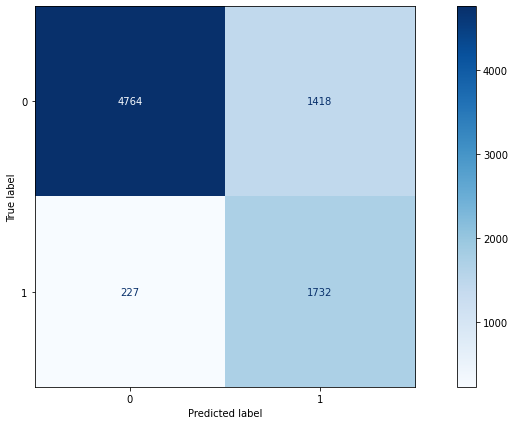

In [37]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(rfc2, X_test_2, y_test_2, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Podemos notar que, si bien la cantidad de falsos negativos disminuyó rotúndamente (en comparación a otros modelos) al cantidad de falsos positivos aumentó mucho (Con un valor cercano a los verdaderos positivos, lo cual es preocupante)


Veamos la curva Roc y su puntuación AUC:

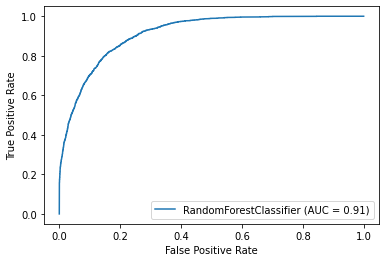

In [38]:
plot_roc_curve(rfc2, X_test_2, y_test_2)

In [39]:
print("El score de RocAUC es de: ", round(roc_auc_score(y_test_2, rfc2.predict_proba(X_test_2)[:, 1]), 4))

El score de RocAUC es de:  0.9132


El valor de RocAUC es alto, pero en realidad no se trata de un buen modelo para predecir todo, sino más bien para casos particulares como aumentar el recall de unos o disminuir la cantidad de falsos negativos.

## Modelo 3 - Sin preprocesamiento

La idea de este modelo es dejar que RandomForest se entrene sin sesgar las features a utilizar (que pueda utilizar absolutamente todas)

Creemos que esto se justifica ya que RandomForest busca realizar la votación de múltiples árboles relativamente diferentes entre sí, por lo que tiene sentido dejar todas las variables.

Veamos qué sucede!

In [40]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X, drop_first=True)
Y = df['tiene_alto_valor_adquisitivo']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, Y, random_state=27)

In [41]:
resultados3 = get_resultados_altura(X_train_3, y_train_3, X_test_3, y_test_3)

Ejecutando altura:  2
Ejecutando altura:  3
Ejecutando altura:  4
Ejecutando altura:  5
Ejecutando altura:  6
Ejecutando altura:  7
Ejecutando altura:  8
Ejecutando altura:  9
Ejecutando altura:  10
Ejecutando altura:  11
Ejecutando altura:  12
Ejecutando altura:  13
Ejecutando altura:  14
Ejecutando altura:  15
Ejecutando altura:  16
Ejecutando altura:  17
Ejecutando altura:  18
Ejecutando altura:  19
Ejecutando altura:  20
Ejecutando altura:  21
Ejecutando altura:  22
Ejecutando altura:  23
Ejecutando altura:  24
Ejecutando altura:  25
Ejecutando altura:  26
Ejecutando altura:  27
Ejecutando altura:  28
Ejecutando altura:  29
Ejecutando altura:  30


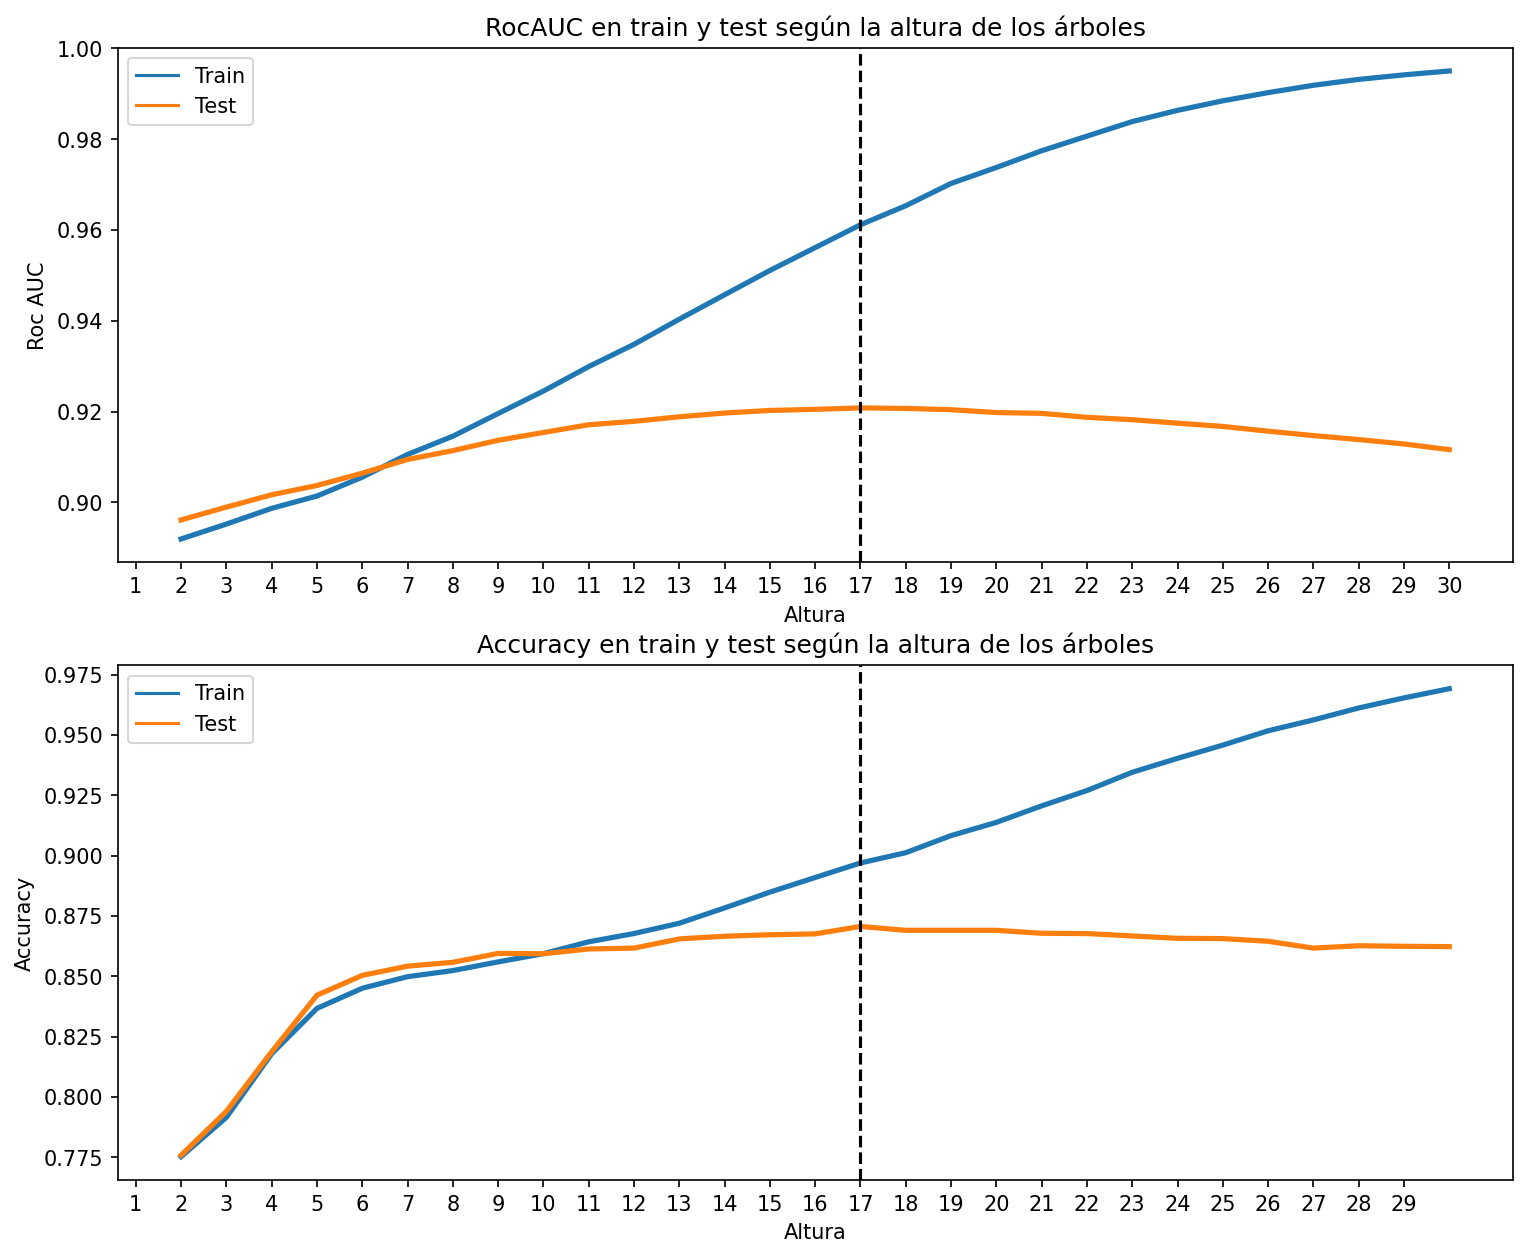

In [42]:
plot_resultados_altura(resultados3)

Podemos ver que el RocAUC tiende a overfittear muy rápidamente pero en cambio el Accuracy no así...

El máximo valor de Accuracy y RocAUC en Test se obtiene para la altura 17, sin embargo podemos ver en los gráficos que la diferencia entre el RocAUC de train y de test para dicha altura es muy grande, por lo que decidimos tomar una más pequeña. En este caso nos quedaremos con altura 10, ya que el Accuracy se mantiene parecido en train y en test y además entre las curvas del RocAUC no hay tanta diferencia.

Entrenemos el modelo entonces

In [46]:
rfc3 = RandomForestClassifier(n_estimators=1001,
                               criterion='gini',
                               max_depth=10,
                               oob_score=True,
                               n_jobs=-1,
                               random_state=27)

In [47]:
rfc3.fit(X_train_3, y_train_3)

RandomForestClassifier(max_depth=10, n_estimators=1001, n_jobs=-1,
                       oob_score=True, random_state=27)

In [49]:
print(classification_report(y_test_3,rfc3.predict(X_test_3), digits=4))

              precision    recall  f1-score   support

           0     0.8671    0.9640    0.9130      6186
           1     0.8236    0.5325    0.6468      1955

    accuracy                         0.8603      8141
   macro avg     0.8453    0.7482    0.7799      8141
weighted avg     0.8566    0.8603    0.8490      8141



Vemos que el modelo obtuvo un accuracy muy alto, de 86%

Además, la precisión para predecir unos y para predecir ceros resulta alta. Sin embargo, como es usual, el recall de unos es bajo (pero relativamente por encima de lo común)

Veamos ahora la matriz de confusión

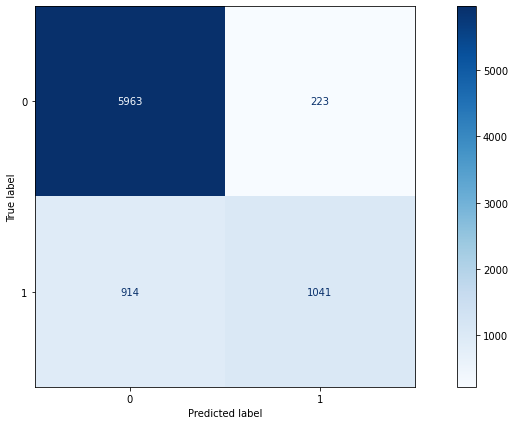

In [51]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(rfc3, X_test_3, y_test_3, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Vemos que nuevamente los falsos negativos suben en cantidad. Es relativamente parecida a las otras matrices de confusión vistas a lo largo del trabajo práctico.

Veamos ahora la curva ROC y su puntuación AUC

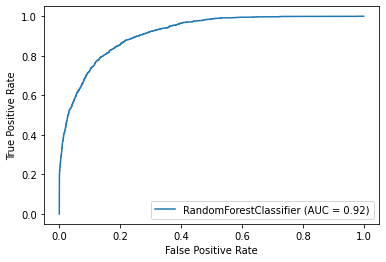

In [52]:
plot_roc_curve(rfc3, X_test_3, y_test_3)

In [53]:
print("El score de RocAUC es de: ", round(roc_auc_score(y_test_3, rfc3.predict_proba(X_test_3)[:, 1]), 4))

El score de RocAUC es de:  0.9153


### Modelo 4 - Preprocessing Significantes 90%


Queremos ver con este modelo si un RandomForest puede aprender de un data frame preprocesado con PCA del 90% de la varianza y los datos previamente escalados con un StandardScaler.

In [54]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X, drop_first=True)
Y = df['tiene_alto_valor_adquisitivo']

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, Y, random_state=112)

X_train_4, X_test_4 = preprocessing_significantes(X_train_4, X_test_4, 0.9)

/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test['ganancia_perdida_declarada_bolsa_argentina'].apply(

In [55]:
resultados4 = get_resultados_altura(X_train_4, y_train_4, X_test_4, y_test_4)

Ejecutando altura:  2
Ejecutando altura:  3
Ejecutando altura:  4
Ejecutando altura:  5
Ejecutando altura:  6
Ejecutando altura:  7
Ejecutando altura:  8
Ejecutando altura:  9
Ejecutando altura:  10
Ejecutando altura:  11
Ejecutando altura:  12
Ejecutando altura:  13
Ejecutando altura:  14
Ejecutando altura:  15
Ejecutando altura:  16
Ejecutando altura:  17
Ejecutando altura:  18
Ejecutando altura:  19
Ejecutando altura:  20
Ejecutando altura:  21
Ejecutando altura:  22
Ejecutando altura:  23
Ejecutando altura:  24
Ejecutando altura:  25
Ejecutando altura:  26
Ejecutando altura:  27
Ejecutando altura:  28
Ejecutando altura:  29
Ejecutando altura:  30


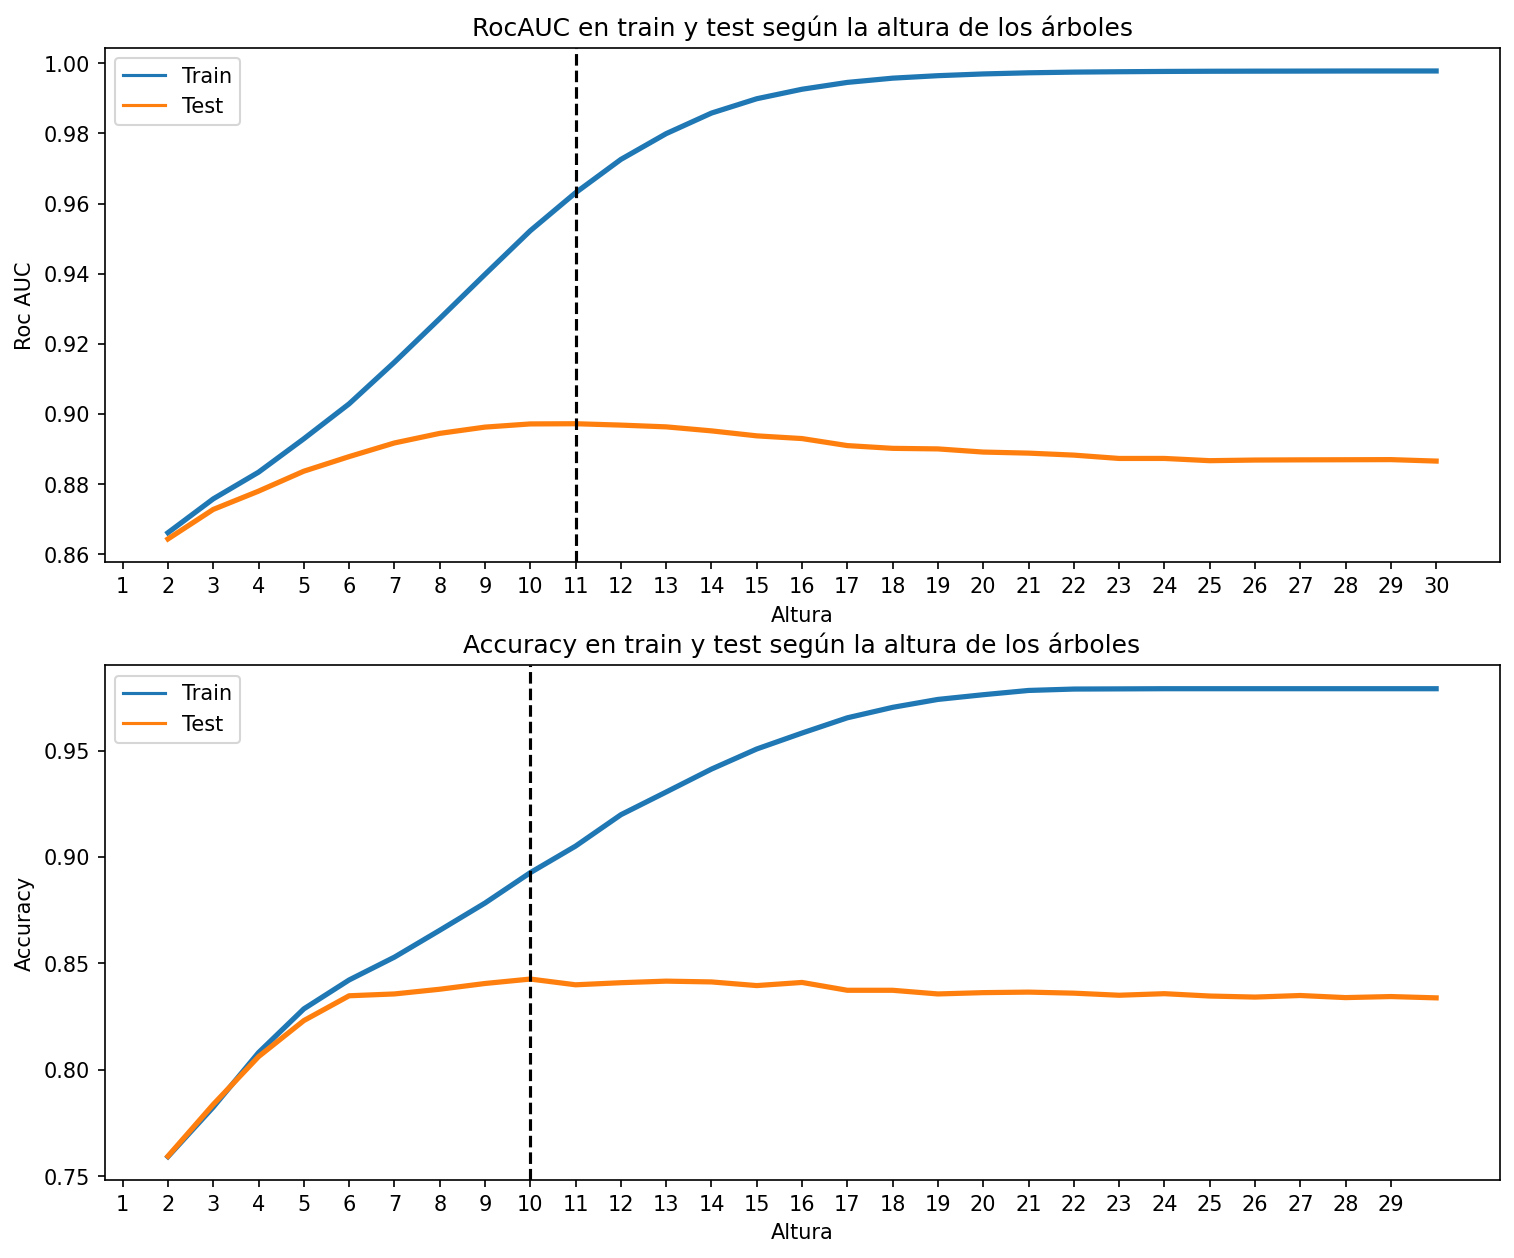

In [56]:
plot_resultados_altura(resultados4)

Vemos que de todos los modelos trabajados en el notebook fue el que más rápido overfitteo para ambas curvas.

Creemos Nos quedaremos con una altura para el árbol de 6, si bien no se alcanza un buen valor allí de RocAUC, no hay tantísima diferencia en Accuracy.

In [57]:
rfc4 = RandomForestClassifier(n_estimators=1001,
                               criterion='gini',
                               max_depth=6,
                               oob_score=True,
                               n_jobs=-1,
                               random_state=27)

In [58]:
rfc4.fit(X_train_4, y_train_4)

RandomForestClassifier(max_depth=6, n_estimators=1001, n_jobs=-1,
                       oob_score=True, random_state=27)

In [60]:
print(classification_report(y_test_4,rfc4.predict(X_test_4), digits=4))

              precision    recall  f1-score   support

           0     0.8499    0.9499    0.8971      6182
           1     0.7484    0.4706    0.5779      1959

    accuracy                         0.8345      8141
   macro avg     0.7991    0.7103    0.7375      8141
weighted avg     0.8255    0.8345    0.8203      8141



El modelo obtuvo un Accuracy de 83.4%, valor bastante malo para tratarse de un ensamble.

Vemos que el recall de unos es pésimo, por lo que la matriz de confusión dará mal, Y por lo demás similar. Realmente no se trata de un buen modelo.

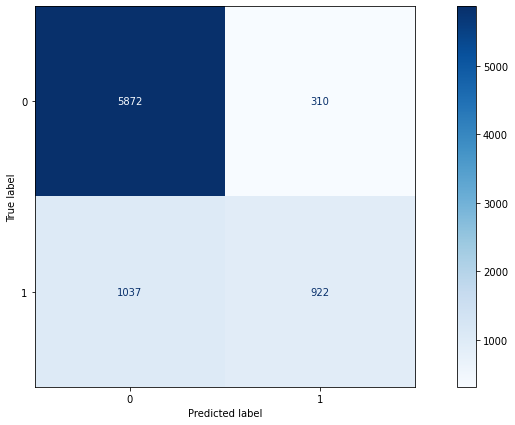

In [61]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(rfc4, X_test_4, y_test_4, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

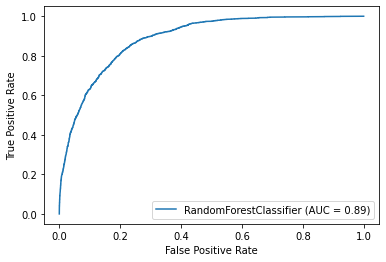

In [62]:
plot_roc_curve(rfc4, X_test_4, y_test_4)

In [63]:
print("El score de RocAUC es de: ", round(roc_auc_score(y_test_4, rfc4.predict_proba(X_test_4)[:, 1]), 4))

El score de RocAUC es de:  0.8879


# Persistiendo los modelos

In [64]:
import pickle

In [65]:
pickle.dump(rfc1, open("Modelos/RandomForest/rfc1.pickle", "wb"))
pickle.dump(rfc2, open("Modelos/RandomForest/rfc2.pickle", "wb"))
pickle.dump(rfc3, open("Modelos/RandomForest/rfc3.pickle", "wb"))
pickle.dump(rfc4, open("Modelos/RandomForest/rfc4.pickle", "wb"))

# Predicción de HoldOut

Usaremos para predecir el RandomForest obtenido para el preprocessing "sin preprocessing"

In [ ]:
rfc3 = pickle.load(open("Modelos/RandomForest/rfc3.pickle", "rb"))

In [66]:
def holdout():
    dfv = utils.get_data()
    Xv = dfv[dfv.columns.drop('tiene_alto_valor_adquisitivo')]
    Xv = pd.get_dummies(Xv, drop_first=True)

    ids, X = utils.get_holdout_data()
    X = pd.get_dummies(X, drop_first=True)
    
    notInHoldout=[]
    for c in Xv.columns:
        if c not in X.columns:
            notInHoldout.append(c)
    X[notInHoldout] = 0

    return ids, X

In [67]:
ids, X = holdout()

In [68]:
utils.escribir_holdout(rfc3.predict(X), "5 - RandomForest", ids)